In [4]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf
import pandas as pd
import shutil
import os

# Formulation of the Problem

We train on a series of 10 blocks. The system of equations can be rewritten as follows:

\begin{align*}
\dot{\bar{u}}_j &= \bar{v}_j \\
\dot{\bar{v}}_j &= \gamma_\mu^2 (\bar{u}_{j-1} - 2\bar{u}_j + \bar{u}_{j+1}) - \gamma_\lambda^2 \bar{u}_j - \frac{\gamma_\mu^2}{\xi} (\bar{f} + \bar{\theta}_j + \ln(\bar{v}_{j+1})) \\
\dot{\bar{\theta}} &= -(\bar{v}_{j+1})(\bar{\theta}_j + (1 + \epsilon) \ln(\bar{v}_{j+1}))
\end{align*}

where $\bar{u}_j$ is non-dimensional relative slip to the driving plate, $\bar{v}_j$ is the non-dimensional slip rate, and $\bar{\theta}_j$ is a scaled non-dimensional state variable of $j$th block. $\gamma_\mu$ and $\gamma_\lambda$ represents the stiffness of spring connecting between blocks and leaf spring, respectively. $\xi$ is non-dimensional spring constant. $\bar{f}$ is the scaled steady-state friction coefficient. Our goal is to predict parameter $\epsilon$ and $\bar{\theta}$, given the measurements of $\bar{u}_j$ and $\bar{v}_j$.|

# Import Dataset

This code loads data from a CSV file (without headers) and organizes it into a dictionary. The first column is reshaped into a 2D array and stored as `t`. Then, a loop iterates 10 times, reshaping columns 1–10 into arrays stored as `u1` to `u10`, and columns 11–20 into arrays stored as `v1` to `v10`.

In [13]:
df = pd.read_csv('./../Dataset/sbm10.csv', header=None)

n = 10    # number of blocks

observe = {}
observe['t'] = df[df.columns[0]].values.reshape((-1, 1))

for i in range(1,11,1):
  observe['u'+str(i)] = df[df.columns[i]].values.reshape((-1, 1))
  observe['v'+str(i)] = df[df.columns[n+i]].values.reshape((-1, 1))

This code creates a dictionary, observe_dde, to store measurements generated from data in the observe dictionary. For each iteration from 1 to 10:

- Measurement loss for "u" values:
It uses the time data (observe['t']) and the corresponding u data (observe['u'+str(i)]) to create a measurement loss via dde.icbc.PointSetBC, assigning a component index of i-1.

- Measurement loss for "v" values:
It uses the time data (observe['t']) and the corresponding v data (observe['v'+str(i)]) to create another measurement loss, but with a component index of n+i-1.

In [6]:
observe_dde = {}
for i in range(1,11,1):
  observe_dde['u'+str(i)] = dde.icbc.PointSetBC(observe['t'], observe['u'+str(i)], component=i-1)
  observe_dde['v'+str(i)] = dde.icbc.PointSetBC(observe['t'], observe['v'+str(i)], component=n+i-1)

# Define Parameters and System of ODEs

In [7]:
horizontal = 0.5      # gamma_mu
vertical = 0.2**0.5   # gamma_lambda
psi = 0.5
f = 3.2

This function defines an ODE system by splitting the input `y` into three parts:

- `u`: first 10 columns
- `v`: next 10 columns
- `theta`: last 10 columns
It then computes gradients (Jacobian) with respect to x for each component and constructs loss terms based on the system of ODEs.

All loss terms are collected in the list f_loss, which the function returns as the residuals for the ODE system.

In [8]:
def ode_system(x, y):

  u = y[:,0:10]
  v = y[:,10:20]
  theta = y[:,20:30]

  du_t = {}
  dv_t = {}
  dt_t = {}

  f_loss = []

  for m in range(n):
    du_t[str(m)] = dde.grad.jacobian(y, x, i=m)
    dv_t[str(m)] = dde.grad.jacobian(y, x, i=n+m)
    dt_t[str(m)] = dde.grad.jacobian(y, x, i=2*n+m)

  for p in range(n):
    loss_temp1 = du_t[str(p)] - y[:,n+p:n+p+1]
    f_loss.append(loss_temp1)

  loss_v1 = dv_t['0'] - horizontal**2*(-y[:,0:1]+y[:,1:2])+vertical**2*y[:,0:1]+(horizontal**2/psi)*tf.sign(y[:,n:n+1]+1)*(f+(y[:,2*n:2*n+1])+tf.log(tf.abs(y[:,n:n+1]+1)))
  loss_vn = dv_t[str(n-1)] - horizontal**2*(y[:,n-2:n-1]-y[:,n-1:n])+vertical**2*y[:,n-1:n]+(horizontal**2/psi)*tf.sign(y[:,2*n-1:2*n]+1)*(f+(y[:,3*n-1:3*n])+tf.log(tf.abs(y[:,2*n-1:2*n]+1)))
  f_loss.append(loss_v1)
  f_loss.append(loss_vn)

  for q in range(1,n-1,1):
    loss_temp2 = dv_t[str(q)] - horizontal**2*(y[:,q-1:q]-2*y[:,q:q+1]+y[:,q+1:q+2])+vertical**2*y[:,q:q+1]+(horizontal**2/psi)*tf.sign(y[:,n+q:n+q+1]+1)*(f+(y[:,2*n+q:2*n+q+1])+tf.log(tf.abs(y[:,n+q:n+q+1]+1)))
    f_loss.append(loss_temp2)

  loss_t1 = dt_t['0'] + (tf.abs(y[:,10:11]+1))*(y[:,20:21]+(1+eps_0)*tf.log(tf.abs(y[:,10:11]+1)))
  loss_t2 = dt_t['1'] + (tf.abs(y[:,11:12]+1))*(y[:,21:22]+(1+eps_1)*tf.log(tf.abs(y[:,11:12]+1)))
  loss_t3 = dt_t['2'] + (tf.abs(y[:,12:13]+1))*(y[:,22:23]+(1+eps_2)*tf.log(tf.abs(y[:,12:13]+1)))
  loss_t4 = dt_t['3'] + (tf.abs(y[:,13:14]+1))*(y[:,23:24]+(1+eps_3)*tf.log(tf.abs(y[:,13:14]+1)))
  loss_t5 = dt_t['4'] + (tf.abs(y[:,14:15]+1))*(y[:,24:25]+(1+eps_4)*tf.log(tf.abs(y[:,14:15]+1)))
  loss_t6 = dt_t['5'] + (tf.abs(y[:,15:16]+1))*(y[:,25:26]+(1+eps_5)*tf.log(tf.abs(y[:,15:16]+1)))
  loss_t7 = dt_t['6'] + (tf.abs(y[:,16:17]+1))*(y[:,26:27]+(1+eps_6)*tf.log(tf.abs(y[:,16:17]+1)))
  loss_t8 = dt_t['7'] + (tf.abs(y[:,17:18]+1))*(y[:,27:28]+(1+eps_7)*tf.log(tf.abs(y[:,17:18]+1)))
  loss_t9 = dt_t['8'] + (tf.abs(y[:,18:19]+1))*(y[:,28:29]+(1+eps_8)*tf.log(tf.abs(y[:,18:19]+1)))
  loss_t10 = dt_t['9'] + (tf.abs(y[:,19:20]+1))*(y[:,29:30]+(1+eps_9)*tf.log(tf.abs(y[:,19:20]+1)))

  f_loss.append(loss_t1)
  f_loss.append(loss_t2)
  f_loss.append(loss_t3)
  f_loss.append(loss_t4)
  f_loss.append(loss_t5)
  f_loss.append(loss_t6)
  f_loss.append(loss_t7)
  f_loss.append(loss_t8)
  f_loss.append(loss_t9)
  f_loss.append(loss_t10)

  return f_loss



# Compile and Train Model

We define time domain from 0 to 100 in `geom`. $\epsilon$ for all blocks is initialized as 0.2. True $\epsilon$ is 0.5 for the first and last 3 blocks and -0.5 for the middle 4 blocks.
Hyperparameters and Setup:

- `unit` = 32: Sets the number of neurons per hidden layer.
- `epoch` = 60000: Total number of training iterations.
- `learning_rate` = 0.0001: Learning rate for the optimizer.
- `layer` = 5: Number of hidden layers.
- `num_res` = 20000: Number of residual points for the PDE.

In [15]:
geom = dde.geometry.TimeDomain(0, 100)

unit = 32
epoch = 60000
learning_rate = 0.0001
layer = 5
num_res = 20000

eps_0 = dde.Variable(0.2)
eps_1 = dde.Variable(0.2)
eps_2 = dde.Variable(0.2)
eps_3 = dde.Variable(0.2)
eps_4 = dde.Variable(0.2)
eps_5 = dde.Variable(0.2)
eps_6 = dde.Variable(0.2)
eps_7 = dde.Variable(0.2)
eps_8 = dde.Variable(0.2)
eps_9 = dde.Variable(0.2)

resultList = list(observe_dde.values())

data = dde.data.PDE(geom, ode_system, resultList, num_res, 0, num_test = 3000, anchors=observe['t'])
layer_size = [1] + [unit] * layer + [30]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)
# net.apply_output_transform(output_transform)
model = dde.Model(data, net)
model.compile("adam", lr=learning_rate, external_trainable_variables=[eps_0, eps_1, eps_2, eps_3, eps_4, eps_5, eps_6, eps_7, eps_8, eps_9])
# Create output directory for saving checkpoints
path = "./../output/inverse_epsilon/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=500
  )
variable = dde.callbacks.VariableValue(
  [eps_0, eps_1, eps_2, eps_3, eps_4, eps_5, eps_6, eps_7, eps_8, eps_9], period=600, filename="./../output/inverse_epsilon/variables.dat"
)
losshistory, train_state = model.train(iterations=epoch , callbacks=[variable, checker])

dde.saveplot(losshistory, train_state, issave=True, isplot=True, output_dir="./../output/inverse_epsilon/")

Compiling model...
Building feed-forward neural network...
'build' took 0.100629 s

'compile' took 7.528868 s

Initializing variables...
Training model...

0         [1.01e-01, 1.16e-01, 3.19e-02, 1.42e-02, 6.46e-02, 7.77e-01, 4.35e-01, 1.03e-01, 5.21e-03, 1.38e-01, 1.93e+00, 2.13e+00, 2.34e+00, 2.15e+00, 2.52e+00, 3.14e+00, 2.82e-01, 1.13e+00, 1.54e+00, 2.84e+00, 3.44e-02, 3.06e-01, 1.10e-01, 3.42e-03, 6.75e-01, 7.32e-02, 1.68e-01, 1.94e-01, 8.58e-03, 3.71e-02, 5.41e+01, 1.23e+00, 6.04e+01, 8.18e-01, 5.62e+01, 4.16e-01, 5.42e+01, 2.05e-01, 5.13e+01, 2.66e-01, 5.21e+01, 7.96e-01, 5.17e+01, 5.42e-01, 5.09e+01, 5.10e-01, 5.31e+01, 7.61e-01, 5.27e+01, 1.25e+00]    [1.01e-01, 1.16e-01, 3.20e-02, 1.42e-02, 6.46e-02, 7.79e-01, 4.36e-01, 1.03e-01, 5.21e-03, 1.38e-01, 1.93e+00, 2.13e+00, 2.34e+00, 2.15e+00, 2.52e+00, 3.14e+00, 2.80e-01, 1.13e+00, 1.54e+00, 2.84e+00, 3.45e-02, 3.07e-01, 1.10e-01, 3.42e-03, 6.77e-01, 7.32e-02, 1.68e-01, 1.94e-01, 8.54e-03, 3.71e-02, 5.41e+01, 1.23e+00, 6.04e+01,

KeyboardInterrupt: 

# Prediction and Plotting
- `yhat = model.predict(observe['t'])` computes predictions using the trained model with the time data.

- Plotting "u" (Slip) for Block 5
- Plotting "v" (Slip Rate) for Block 5
- Plotting "θ" (State Variable) for Block 5

In [16]:
t = np.linspace(0,100,1000).reshape(-1,1)
yhat = model.predict(observe['t'])

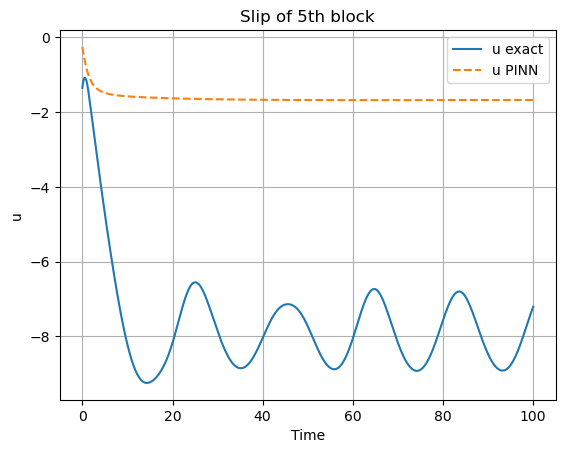

In [17]:
plt.figure()
plt.plot(observe['t'], observe['u'+str(5)], "-", label="u exact")
plt.plot(observe['t'], yhat[:, 4:5], "--", label="u PINN")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('u')
plt.title('Slip of 5th block')
plt.savefig('./../output/inverse_epsilon/pred_u.png')

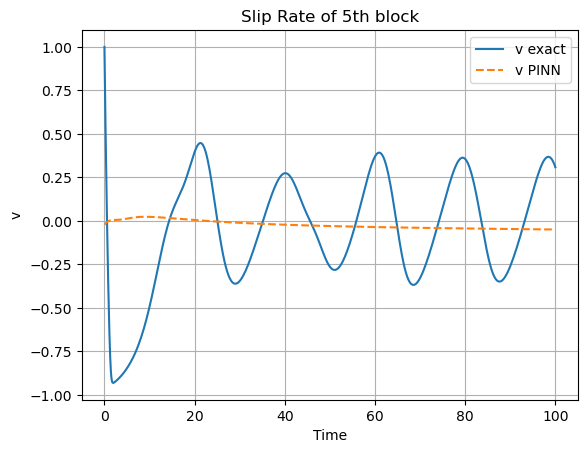

In [18]:
plt.figure()
plt.plot(observe['t'], observe['v'+str(5)], "-", label="v exact")
plt.plot(observe['t'], yhat[:, 14:15], "--", label="v PINN")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Slip Rate of 5th block')
plt.savefig('./../output/inverse_epsilon/pred_v.png')

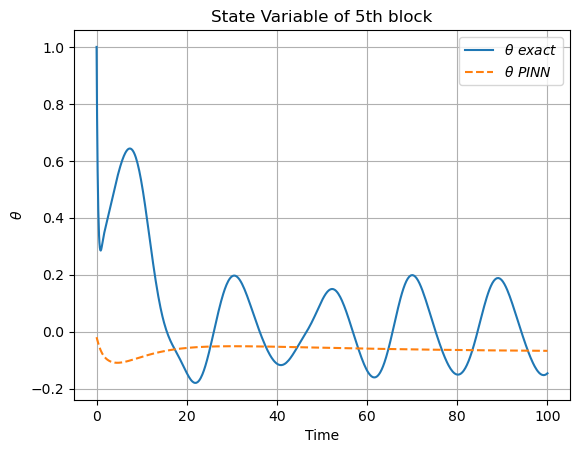

In [19]:
for i in range(1,11,1):
  observe['t'+str(i)] = df[df.columns[2*n+i]].values.reshape((-1, 1))
plt.figure()
plt.plot(observe['t'], observe['t'+str(5)], "-", label=r"${\theta\ exact}$")
plt.plot(observe['t'], yhat[:, 24:25], "--", label=r"${\theta\ PINN}$")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel(r'$\theta$')
plt.title('State Variable of 5th block')
plt.savefig('./../output/inverse_epsilon/pred_theta.png')